In [1]:
import os, re, glob
import numpy as np
import pandas as pd
from timezonefinder import TimezoneFinder

### Extract Files Availability

In [2]:
station_list = pd.read_csv(
    "../../../data/ISD/station_list.csv",
    dtype={'USAF': str, 'WBAN': str}
)
station_list["id"] = station_list['USAF'] + station_list['WBAN']
us_stations = [(11-len(s))*'0'+s for s in station_list.loc[station_list["CTRY"]=="US", "id"].values]

In [4]:
files = glob.glob("../../../data/ISD/**/*.csv", recursive=True)
files.sort()

df_files = pd.DataFrame(
    data=[[os.path.basename(os.path.dirname(f)), os.path.basename(f).split('.')[0]] for f in files],
    columns=['year', 'station']
)
df_files["availability"] = 1
df_files

,year,station,availability
0,1901,02907099999,1
1,1901,02950099999,1
2,1901,02960099999,1
3,1901,02972099999,1
4,1901,02981099999,1
...,...,...,...
671792,2022,A5125600451,1
671793,doc,sample,1
671794,ISD,files_summary,1
671795,ISD,isd-inventory,1


In [5]:
test = df_files.set_index(["year", "station"])
test.loc[test.index.duplicated()]

,,availability
year,station,


In [6]:
files_avail = df_files.pivot(index="year", columns="station", values="availability")
files_avail

station,00701899999,00702699999,00707099999,00826099999,00826899999,00830799999,00841199999,00841499999,00841599999,00841899999,...,A0735400132,A0735500241,A0735700182,A0735900240,A5125500445,A5125600451,files_summary,isd-inventory,sample,station_list
year,,,,,,,,,,,,,,,,,,,,,
1901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [7]:
files_avail.loc["1973", ["01001099999"]]

station
01001099999    1.0
Name: 1973, dtype: float64

In [8]:
# column_frame = files_avail[["72784524163"]].iloc[:-1].astype("float")
# column_frame = column_frame.reset_index()
# column_frame.groupby(
#     (~(column_frame["72784524163"]==1)).cumsum()
# ).agg(
#     {'year': ['count', 'min', 'max']}
# ).droplevel(0, axis=1)#.astype("int")

In [9]:
def get_min_max(ds):
    column_frame = ds.reset_index()
    agg_frame = column_frame.groupby(
        (~(column_frame[ds.name]==1)).cumsum()
    ).agg(
        {'year': ['count', 'min', 'max']}
    ).droplevel(0, axis=1).astype("int")
    
    try:
        max_series = agg_frame[agg_frame["count"]==agg_frame["count"].max()].iloc[-1]
    except:
        print(ds.name, agg_frame)
        return pd.Series()
    max_series.name = ds.name
    return max_series

In [10]:
avail_file = "../../../data/ISD/files_summary.csv"
if os.path.exists(avail_file):
    avail_summary = pd.read_csv(avail_file, index_col="station")
else:
    avail_summary = files_avail.iloc[:-1].apply(get_min_max).T
    avail_summary.to_csv(avail_file)

avail_summary

,count,min,max
station,,,
00701899999,2,2012,2013
00702699999,3,2015,2017
00707099999,3,2013,2015
00826099999,7,2004,2010
00826899999,4,2009,2012
...,...,...,...
A0735700182,10,2013,2022
A0735900240,10,2013,2022
A5125500445,10,2013,2022


In [11]:
sel_stations = avail_summary[
    (avail_summary["count"]>50) & 
    (avail_summary["max"]==2022)
]
print("[INFO] Total number of stations selected: %d" %(sel_stations.shape[0]))
print("[INFO] Year Range: (%d, %d)" %(sel_stations["min"].max(), sel_stations["max"].min()))

[INFO] Total number of stations selected: 3080
[INFO] Year Range: (1972, 2022)


In [12]:
sel_us_stations = [s for s in sel_stations.index.values if s in us_stations]
us_stations_info = sel_stations.loc[sel_us_stations]
print("[INFO] Total number of stations selected: %d" %(us_stations_info.shape[0]))

[INFO] Total number of stations selected: 353


### Reading Sample File

In [13]:
df = pd.read_csv(
    f"../../../data/ISD/1973/%s.csv" %(us_stations_info.index.values[0]), 
    index_col="DATE", parse_dates=True,
    dtype={"STATION": str}
)
df.head()

,STATION,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,WND,...,MD1,MW1,MW2,MW3,MW4,MW5,OC1,UA1,REM,EQD
DATE,,,,,,,,,,,,,,,,,,,,,
1973-01-01 00:00:00,70026027502,3,71.2834,-156.7815,9.4,"BARROW AIRPORT, AK US",SY-SA,BRW,V020,"110,5,N,0031,5",...,"6,1,002,1,+999,9","02,1",NaN,NaN,NaN,NaN,NaN,NaN,NaN,N01 00000JPWTH 1
1973-01-01 01:00:00,70026027502,4,71.2834,-156.7815,9.4,"BARROW AIRPORT, AK US",SAO,BRW,V020,"110,1,N,0030,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-01 02:00:00,70026027502,4,71.2834,-156.7815,9.4,"BARROW AIRPORT, AK US",SAO,BRW,V020,"120,1,N,0036,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-01 03:00:00,70026027502,3,71.2834,-156.7815,9.4,"BARROW AIRPORT, AK US",SAO,BRW,V020,"130,5,N,0031,5",...,NaN,"45,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,N01 07100JPWTH 1
1973-01-01 04:00:00,70026027502,4,71.2834,-156.7815,9.4,"BARROW AIRPORT, AK US",SAO,BRW,V020,"130,1,N,0041,1",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def process_df(df_func):
    df_func[["WND_DA", "WND_DA_Q", "WND_Type", "WND_Speed", "WND_Speed_Q"]] = df_func["WND"].str.split(",", expand=True)
    df_func[["CIG_AGL", "CIG_AGL_Q", "CIG_AGLM", "CIG_CAVOK"]] = df_func["CIG"].str.split(",", expand=True)
    df_func[["VIS_DIS", "VIS_DIS_Q", "VIS_DISV", "VIS_DISV_Q"]] = df_func["VIS"].str.split(",", expand=True)
    df_func[["TMP_C", "TMP_C_Q"]] = df_func["TMP"].str.split(",", expand=True)
    df_func[["DEW_C", "DEW_C_Q"]] = df_func["DEW"].str.split(",", expand=True)
    df_func[["SLP_HP", "SLP_HP_Q"]] = df_func["SLP"].str.split(",", expand=True)
    # df_func[[
    #         "WND_DA", "WND_DA_Q", "WND_Type", "WND_Speed", "WND_Speed_Q", \
    #         "CIG_AGL", "CIG_AGL_Q", "CIG_AGLM", "CIG_CAVOK", \
    #         "VIS_DIS", "VIS_DIS_Q", "VIS_DISV", "VIS_DISV_Q", \
    #         "TMP_C", "TMP_C_Q", \
    #         "DEW_C", "DEW_C_Q", \
    #         "SLP_HP", "SLP_HP_Q"
    #     ]]
    
    df_func = df_func.loc[
        ((df_func["TMP_C_Q"]=='1') & (df_func["SLP_HP_Q"]=='1')), 
        ['STATION', 'LATITUDE', 'LONGITUDE', 'NAME', "TMP_C", "SLP_HP"]
    ]
    if df_func.empty:
        return None
    
    df_func["TMP_C"] = df_func["TMP_C"].replace("+9999", pd.NA).astype("int") / 10
    df_func["SLP_HP"] = df_func["SLP_HP"].replace("99999", pd.NA).astype("int") / 10

    # latitude = df_func['LATITUDE'].values[0]
    # longitude = df_func['LONGITUDE'].values[0]
    
    # timezone = tzfinder.timezone_at(lng=longitude, lat=latitude)
    # print(f"[INFO] Station:%s; Timezone: %s" %(df_func.iloc[0]["NAME"], timezone))

    return df_func#.tz_localize("UTC").tz_convert("America/Los_Angeles")

In [15]:
df_out = process_df(df)
df_out

,STATION,LATITUDE,LONGITUDE,NAME,TMP_C,SLP_HP
DATE,,,,,,
1973-01-01 01:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-38.0,1034.5
1973-01-01 02:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-38.0,1034.2
1973-01-01 04:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-38.0,1033.5
1973-01-01 05:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-37.2,1032.8
1973-01-01 07:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-36.0,1031.8
...,...,...,...,...,...,...
1973-12-31 14:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-3.8,1000.9
1973-12-31 19:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-8.3,1002.9
1973-12-31 20:00:00,70026027502,71.2834,-156.7815,"BARROW AIRPORT, AK US",-8.3,1003.7


<AxesSubplot:xlabel='DATE'>

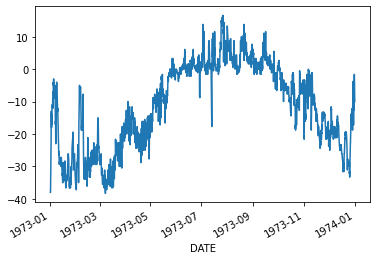

In [16]:
df_out["TMP_C"].plot()

### Combine Data

In [45]:
import re, sys
def process_year(year, tzfinder):
    station_info = []
    temp_data = {}
    pressure_data = {}

    for s in us_stations_info.index.values:
        # read and process data
        df = pd.read_csv(
            f"../../../data/ISD/%d/%s.csv" %(year, s), 
            index_col="DATE", parse_dates=True,
            dtype={"STATION": str}
        )
        df_out = process_df(df)
        
        # split temperature data, pressure data, and station info
        if df_out is not None:
            station_dict = df_out.iloc[0][
                ['STATION', 'LATITUDE', 'LONGITUDE', 'NAME']
            ].to_dict()
            station_dict["TIMEZONE"] = tzfinder.timezone_at(
                lng=station_dict['LONGITUDE'], 
                lat=station_dict['LATITUDE']
            )

            station_info.append(station_dict)
            temp_data[s] = df_out["TMP_C"].to_dict()
            pressure_data[s] = df_out["SLP_HP"].to_dict()

    # output folder
    year_folder = f"../../../data/ISDProcessed/%d" %(year)
    if not os.path.exists(year_folder):
        os.makedirs(year_folder)
    
    # get station info
    df_stations = pd.DataFrame(station_info)
    df_stations[["LOC", "STATE"]] = df_stations["NAME"].str.split(",", expand=True)
    df_stations["COUNTRY"] = df_stations["STATE"].str[-2:]
    df_stations["STATE"] = df_stations["STATE"].str[1:3]
    df_stations.to_csv(
        os.path.join(year_folder, "station_info.csv") 
    )

    # temperature frame
    temperature_frame = pd.DataFrame(temp_data)
    temperature_frame.to_csv(
        os.path.join(year_folder, "temperature.csv") 
    )

    # pressure frame
    pressure_frame = pd.DataFrame(pressure_data)
    pressure_frame.to_csv(
        os.path.join(year_folder, "pressure.csv") 
    )

    return df_stations, temperature_frame, pressure_frame

In [46]:
obj = TimezoneFinder()
process_year(1973, obj)

(         STATION  LATITUDE  LONGITUDE  \
 0    70026027502  71.28340 -156.78150   
 1    70133026616  66.86670 -162.63330   
 2    70174026533  66.91690 -151.51540   
 3    70178026529  65.17500 -152.10670   
 4    70200026617  64.51110 -165.44000   
 ..           ...       ...        ...   
 332  91165022536  21.98389 -159.34056   
 333  91176022519  21.45045 -157.76794   
 334  91182022521  21.32400 -157.92940   
 335  91190022516  20.89972 -156.42861   
 336  91285021504  19.71910 -155.05300   
 
                                                   NAME           TIMEZONE  \
 0                                BARROW AIRPORT, AK US  America/Anchorage   
 1                              KOTZEBUE AIRPORT, AK US       America/Nome   
 2                               BETTLES AIRPORT, AK US  America/Anchorage   
 3                                TANANA AIRPORT, AK US  America/Anchorage   
 4                                  NOME AIRPORT, AK US       America/Nome   
 ..                       

### Reading Combined Data File

In [2]:
df_temp = pd.read_csv("../../../data/ISDProcessed/2019/wona_temp.csv", index_col=[0], parse_dates=True)
display(df_temp)

df_pressure = pd.read_csv("../../../data/ISDProcessed/2019/wona_pressure.csv", index_col=[0], parse_dates=True)
display(df_pressure)

,72517014737,72306013722,72651014944,72231012916,72662024090,72334013893,72768094008,72465023065,72637014826,72310013883,...,72351013966,72536614825,72248013957,72643514991,72508014740,72228013876,72507014765,72518014735,72308013737,72206593837
2019-01-01 00:00:00,6.10,17.5,-14.033333,20.3,-14.4,10.575,-20.0,-10.0,4.033333,18.95,...,6.65,15.600000,9.45,-3.3,2.800000,17.766667,4.15,3.900000,16.150,22.2
2019-01-01 01:00:00,6.10,18.3,-15.200000,18.9,-14.4,10.000,-20.6,-10.6,4.050000,19.40,...,5.60,16.100000,8.30,-4.1,2.800000,17.200000,3.90,3.900000,17.800,21.7
2019-01-01 02:00:00,5.60,18.9,-15.000000,18.9,-14.4,9.400,-20.0,-12.2,3.133333,20.00,...,4.40,14.466667,7.80,-4.4,3.050000,16.400000,3.90,3.900000,18.950,21.1
2019-01-01 03:00:00,5.95,18.9,-15.600000,18.9,-15.0,9.400,-22.2,-12.2,1.950000,20.00,...,3.60,10.800000,7.50,-5.3,3.300000,16.700000,5.00,4.233333,19.175,20.6
2019-01-01 04:00:00,6.05,19.4,-16.700000,19.4,-15.0,8.900,-22.8,-12.8,1.100000,20.00,...,2.20,9.450000,8.30,-5.9,3.300000,16.700000,5.60,4.400000,19.300,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,7.80,14.4,-5.600000,16.7,0.0,10.000,-1.1,6.1,-0.600000,15.00,...,11.70,-0.850000,13.90,-4.4,2.133333,11.700000,5.00,3.300000,14.400,19.4
2019-12-31 20:00:00,7.20,13.9,-5.000000,17.2,0.0,10.000,0.0,6.7,-0.600000,15.00,...,12.20,-1.066667,13.90,-4.4,1.700000,12.200000,4.40,3.300000,14.400,19.4
2019-12-31 21:00:00,6.70,12.8,-5.000000,16.7,1.4,9.700,1.7,7.2,-1.050000,13.90,...,12.80,-1.400000,13.60,-5.0,1.300000,11.700000,4.40,3.300000,13.850,19.4
2019-12-31 22:00:00,6.70,10.0,-5.600000,15.6,0.0,8.300,1.1,4.4,-1.100000,12.20,...,11.70,-1.700000,12.20,-6.1,1.700000,10.600000,3.30,2.800000,9.400,17.8


,72517014737,72306013722,72651014944,72231012916,72662024090,72334013893,72768094008,72465023065,72637014826,72310013883,...,72351013966,72536614825,72248013957,72643514991,72508014740,72228013876,72507014765,72518014735,72308013737,72206593837
2019-01-01 00:00:00,1017.45,1018.35,1024.05,1015.95,1034.95,1014.40,1037.9,1023.45,998.2,1017.8,...,1014.15,997.2,1014.25,1015.2,1021.5,1016.5,1023.55,1018.60,1017.80,1020.0
2019-01-01 01:00:00,1014.50,1017.40,1026.00,1016.50,1035.40,1015.50,1037.9,1025.40,997.4,1018.2,...,1017.10,998.0,1015.70,1016.6,1018.0,1016.5,1021.70,1015.10,1016.80,1020.1
2019-01-01 02:00:00,1012.60,1016.70,1027.00,1016.50,1035.90,1016.30,1037.1,1027.00,998.5,1018.0,...,1018.60,1000.0,1016.60,1017.8,1016.4,1016.4,1018.30,1013.10,1016.40,1020.5
2019-01-01 03:00:00,1010.50,1016.10,1029.00,1016.80,1035.60,1016.55,1036.6,1029.00,1000.1,1017.3,...,1020.10,1002.4,1016.80,1019.4,1014.4,1016.6,1016.00,1011.75,1015.85,1020.5
2019-01-01 04:00:00,1009.00,1014.50,1029.10,1016.80,1035.60,1017.30,1036.3,1030.10,1003.4,1017.4,...,1020.70,1003.9,1017.20,1020.7,1012.4,1017.1,1013.40,1007.80,1014.20,1020.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1002.70,1008.10,1013.80,1021.40,1011.40,1018.50,1006.5,1016.80,1002.4,1011.6,...,1022.20,1006.1,1022.20,1007.6,1001.6,1018.6,1001.20,1001.20,1006.40,1016.1
2019-12-31 20:00:00,1002.80,1008.60,1013.40,1020.80,1010.90,1018.40,1005.8,1015.50,1003.4,1011.9,...,1020.70,1007.2,1021.00,1008.1,1001.8,1018.4,1001.00,1001.70,1006.70,1016.0
2019-12-31 21:00:00,1002.80,1008.80,1013.40,1020.40,1010.95,1018.30,1005.6,1015.10,1004.3,1012.1,...,1020.30,1008.0,1021.00,1008.5,1001.9,1018.3,1001.40,1001.55,1006.80,1016.2
2019-12-31 22:00:00,1003.10,1009.10,1013.10,1020.50,1011.00,1018.30,1004.9,1015.20,1005.3,1012.3,...,1020.20,1008.7,1020.80,1009.0,1001.9,1018.5,1001.80,1001.60,1007.20,1016.7


In [8]:
print(df_temp.stack().mean(), df_temp.stack().std(), df_pressure.stack().mean(), df_pressure.stack().std())

13.287549251670859 11.561990413857787 1016.1592482094989 7.502707764516302


In [26]:
data_count = df_temp.resample('1H').mean().count().sort_values(ascending=True)#.ffill().bfill().plot()
data_count[data_count > 5000]

91285021504    5225
72362723081    5228
72365823090    5275
91165022536    5355
72583024128    5473
               ... 
72259793985    8537
72589594236    8707
72622794790    8710
72351013966    8745
91182022521    8760
Length: 181, dtype: int64

In [19]:
df_temp["70260026435"].dropna()

1973-05-06 18:00:00    7.2
Name: 70260026435, dtype: float64